In [284]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate
import time
rng = np.random.default_rng()

In [101]:
def f_pi(x, mu, sigma, alpha):
    val = 0
    for i in range(len(mu)):
        val += alpha[i]*norm.pdf(x, mu[i], sigma[i])
    return val
    
def f_eta_unnormalized(x, mu, sigma, alpha, p):
    return f_pi(x, mu, sigma, alpha)**p

def compute_c(mu, sigma, alpha, p):
    def f_eta_unnormalized_temp(x):
        return f_eta_unnormalized(x, mu, sigma, alpha, p)
    c = integrate.quad(f_eta_unnormalized_temp, -np.inf, np.inf)[0]
    return c

# c = compute_c(mu, sigma, alpha, p)
    
def f_eta(x, mu, sigma, alpha, p, c):
    return f_eta_unnormalized(x, mu, sigma, alpha, p)/c

def g(x, mu, sigma, alpha, p, c):
    return(f_pi(x, mu, sigma, alpha)/f_eta(x, mu, sigma, alpha, p, c))

In [105]:
c = compute_c(mu,sigma,alpha,p)

In [15]:
def p_kernel(y0, prop_sig_y, n, mu, sigma, alpha, p):
        count = 0
        Yn = y0
        estimator = np.array([y0])
        while count < n:
            y = np.random.normal(Yn, prop_sig_y)
            u = np.random.uniform(0,1)
            a = min(f_eta_unnormalized(y, mu, sigma, alpha, p)/f_eta_unnormalized(Yn, mu, sigma, alpha, p), 1)
            if u <= a:
                estimator = np.append(estimator, y)
                Yn = y
                count += 1
        return estimator

In [16]:
def k_kernel_nsteps(z0, prop_sig_z, n, mu, sigma, alpha):
        count = 0
        Zn = z0
        estimator = np.array([z0])
        while count < n:
            z = np.random.normal(Zn, prop_sig_z)
            u = np.random.uniform(0,1)
            a = min(f_pi(z, mu, sigma, alpha)/f_pi(Zn, mu, sigma, alpha), 1)
            if u <= a:
                estimator = np.append(estimator, z)
                Zn = z
                count += 1
        return estimator

In [17]:
def k_kernel(Xn, prop_sig_x, mu, prop_sig_x, alpha):
    Xnew = k_kernel_nsteps(Xn, prop_sig_x, 1, mu, sigma, alpha)[-1]
    return(Xnew)

In [7]:
def sum_g(sum_old, yn, mu, sigma, alpha, p, c):
    return sum_old + sum_old + sum(g(yn, mu, sigma, alpha, p, c))

def prob_list(y, sum_old, prob_list_old, mu, sigma, alpha, p, c):
        #a = sum_old/sum_g(sum_old, y, mu, sigma, alpha, p, c)
        #prob_list = prob_list_old*a
        prob_list_new = g(y, mu, sigma, alpha, p, c)/sum_g(sum_old, y, mu, sigma, alpha, p, c)
        #prob_list = np.insert(prob_list, len(prob_list[0]), prob_list_new, axis=1)
        return prob_list_new

In [65]:
def generate_y_data(y0, prop_sig_y, n, mu, sigma, alpha, p, N):
    Y_mat = np.zeros((N,n))
    for i in range(N):
        Y_mat[i,] = p_kernel(y0[i], prop_sig_y, n-1, mu, sigma, alpha, p)
    return Y_mat

In [136]:
####Testing some functions

Y_dat_test[0]

sum(g(Y_dat_test[0],mu,sigma,alpha,p,c))

Y_dat_test[0]*1/2

prob_matrix_rescaled = np.array([[0.1,.05,.05],[.3,.2,.3]])
prob_matrix_rescaled

sum_old = 10
newys = np.array([[5],[10]])
newgs = g(newys, mu, sigma, alpha, p, c)
sum_new = sum_old + sum(newgs)

prob_mat_res = prob_matrix_rescaled*sum_old/sum_new

prob_matrix_new_cl = newgs/sum_new
print(prob_mat_res)
np.concatenate((prob_mat_res, prob_matrix_new_cl), axis=1)

[[0.08612895 0.04306448 0.04306448]
 [0.25838686 0.1722579  0.25838686]]


array([[0.08612895, 0.04306448, 0.04306448, 0.09699404],
       [0.25838686, 0.1722579 , 0.25838686, 0.04171644]])

In [306]:
#This function serve the same purpose as prob_matrix
def update_y_prob_mat(new_y, sum_old, prob_matrix_old, mu, sigma, alpha, p, c):
    new_g_vals = g(new_y, mu, sigma, alpha, p, c)
    sum_new = sum_old + sum(new_g_vals)
    prob_matrix_rescaled = prob_matrix_old*sum_old/sum_new
    prob_matrix_new_col = new_g_vals/sum_new
    prob_matrix_new = np.concatenate((prob_matrix_rescaled, prob_matrix_new_col), axis=1)
    return(prob_matrix_new, sum_new)

In [8]:
def prob_matrix(Y_list, sum_old, prob_matrix_old, mu, sigma, alpha, p, c):
        g_value = 0
        for i in (Y_list):
            g_value += g(i, mu, sigma, alpha, p, c)
        sum_new = sum_old+g_value
        a = sum_old/sum_new
        prob_matrix = prob_matrix_old*a
        for i in range(len(Y_list)):
            Y_list [i] = g(Y_list[i], mu, sigma, alpha, p, c)/sum_new
        prob_matrix = np.insert(prob_matrix,len(prob_matrix[0])-1,Y_list,axis=1)
        return prob_matrix

In [369]:
def simulate(mu, sigma, alpha, p, n, y0_list, prop_sig_x, prop_sig_y, x0_list, eps, N):
    
    c = compute_c(mu, sigma, alpha, p)
    
    #Generate all of the Y data
    Y_matrix = generate_y_data(y0, prop_sig_y, n, mu, sigma, alpha, p, N)
    
    #Initialize the probabillity matrix
    sum_old = sum(g(Y_matrix[:,0], mu, sigma, alpha, p, c))
    prob_matrix_old = np.transpose(np.array([g(Y_matrix[:,0], mu, sigma, alpha, p ,c)]/sum_old))
    
    #Initialize the matrix of X data
    
    X_matrix = np.transpose(np.array([x0_list]))
 
    for i in range(1,n):
        
        #Update the probability matrix using the i-th column of Y data
        prob_matrix_new = update_y_prob_mat(np.transpose([Y_matrix[:,i]]), sum_old, prob_matrix_old, mu, sigma, alpha, p, c)
        
        #Extract the sum of all g(Y) values so far
        sum_new = prob_matrix_new[1]
        sum_old = sum_new
        
        #Extract the value of the updated probability matrix
        prob_matrix_old = prob_matrix_new[0]
        
        #Convert the array of Y positions to a vector
        y_vec = Y_matrix[:,:(i+1)].flatten()
                
        #Convert the probability matrix to a vector
        prob_vec = prob_matrix_old.flatten()
        
        #Generate a new vector of X positions
        x_vec = np.zeros(N)
        for j in range(N):
            b = bernoulli(epsilon).rvs(1)
            if b == 0:
                x_vec[j] = k_kernel(X_matrix[j][i-1], prop_sig_x, mu, sigma, alpha)
            if b == 1:
                x_vec[j] = np.random.choice(y_vec, p = prob_vec)
        X_matrix = np.concatenate((X_matrix, np.transpose([x_vec])), axis=1)
    return(X_matrix)

In [388]:
epsilon = 0.01
y0 = [1,2,3,4]
x0 = [6,7,8,8]
n = 10000
prop_sig_x = 2
prop_sig_y = 2
mu = np.array([0, 3])
sigma = np.array([1, 4])
alpha = np.array([0.3, 0.7])
N = len(x0)
p = 0.4

x_out = simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, epsilon, N)

In [389]:
f_pi_plot = lambda z: f_pi(z, mu, sigma, alpha)
t = np.linspace(-10,15,100)
vals = f_pi_plot(t)

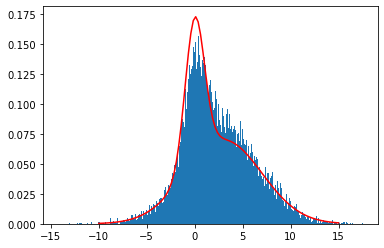

In [390]:
plt.hist(x_out.flatten(), density = True, bins = 1000)
plt.plot(t,vals, 'r')
plt.show()